<a href="https://colab.research.google.com/github/maxsop/R-junk/blob/master/Senior_MLE_Interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below are the instructions for the technical assessment. There are two parts: Data Science and Engineering. You should plan to spend about 1-2 hours on the Data Science portion and 1-2 hours on the engineering portion.

## Data Science

For the Data Science portion, it is important to note that your work won't be assessed on whether you get the best model, but that you understand important concepts behind analyzing the data, feature engineering and model development and evaluation. Keep this section simple, clear and illustrative of your understanding of how to prototype a model.

## Engineering

In a separate set of files (ie not in this Jupyter Notebook), take the model that you created and implement basic training and prediction pipelines that would simulate what you would implement in production. These pipelines should broadly cover the following steps:
* Preprocessing
  * This will be based off the raw data received at the beginning of DS assignment
* Model Training & Evaluation
* Predictions (in batch)

*Some Requirements*:
* The training and prediction pipelines should be independent of each other (though they can draw from the same base methods/classes if need be).
* The prediction job predicts on the latest "promoted" model.
* All model artifacts and outputs are stored according to date partition or, where relevant, by version
* The training job includes logic around "model promotion"
  * If there is an 10% increase in ROC/AUC over the previous model then promote model; else don't promote model
* For both jobs, a user (human or machine) should be able to simply call on the script or import a class to run the pipeline

*Bonus*:

Parameterize the pipelines according to how a Data Scientist would use this.
* Allow for arbitrary set of features to be passed into training (and prediction) job
* Parameterize the % threshold increase to promote a model
* Parameterize which evaluation metric can be used. To keep it simple, stick with most common metrics for evaluation


Organize the files in a folder structure that would emulate how you would organize the code in a Github repo. Zip up all files and send them back to the recruiter by the morning of your interview.

# Data Science Portion

## Imports

In [ ]:
!unzip MLE_Interview.zip

Archive:  MLE_Interview.zip
replace __MACOSX/._Senior MLE Interview? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from IPython.display import clear_output
clear_output()

In [ ]:
! pip install pandas_profiling
! pip install shap
! pip install boruta
clear_output()

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
# Add any other packages you would like to use here
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import  auc, make_scorer, recall_score, precision_score, confusion_matrix, classification_report, accuracy_score, precision_recall_curve,f1_score,roc_auc_score, r2_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from pandas_profiling import ProfileReport
from boruta import BorutaPy
import plotly.express as px
import shap
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, CalibrationDisplay

# To plot pretty figures
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.simplefilter(action='ignore')

pd.options.display.float_format = '{:.3f}'.format

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)

## Dataset

The dataset in this notebook is representive of Vacasa's internal data.

In this notebook, we would like you to develop a model to predict whether a reservation will cancel and describe what the model learned.

* The label in the dataset is given as `is_canceled`.
* For a complete description of dataset, visit the link: https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [ ]:
df = pd.read_csv('Senior MLE Interview/train/hotel_bookings.csv')

In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.000,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.000,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.000,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.000,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.000,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.000,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.000,NaN,0,Transient,75.000,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.000,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.000,NaN,0,Transient,98.000,0,1,Check-Out,2015-07-03


 ## Helpful EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
df['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [ ]:
df['is_canceled'].mean()

0.37041628277075134

In [ ]:
df.shape

(119390, 32)

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [ ]:
profile.to_widgets()

In [ ]:
profile.to_file("EDA_Report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Dealing with missing values

In [ ]:

# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.

nan_dict = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
df = df.fillna(nan_dict)

# "meal" with values "Undefined" should be set to SC.
df['meal'] = df["meal"].replace("Undefined", "SC")

# Some rows contain entriess with 0 adults, 0 children and 0 babies - Let's drop them

zero_guests = list(df.loc[df["adults"]
                   + df["children"]
                   + df["babies"]==0].index)
df = df.drop(df.index[zero_guests])

In [ ]:
df.shape

(119210, 32)

#### Data visualization and feature engineering

In [ ]:
# get number of acutal guests by country
df_ctry = pd.DataFrame(df.loc[df["is_canceled"] == 0]["country"].value_counts())
#country_data.index.name = "country"
df_ctry = df_ctry.rename(columns={"country": "Number of Guests"})
total_guests = df_ctry["Number of Guests"].sum()
df_ctry["Guests in %"] = round(df_ctry["Number of Guests"] / total_guests * 100, 2)
df_ctry["country"] = df_ctry.index

# pie plot
fig = px.pie(df_ctry,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

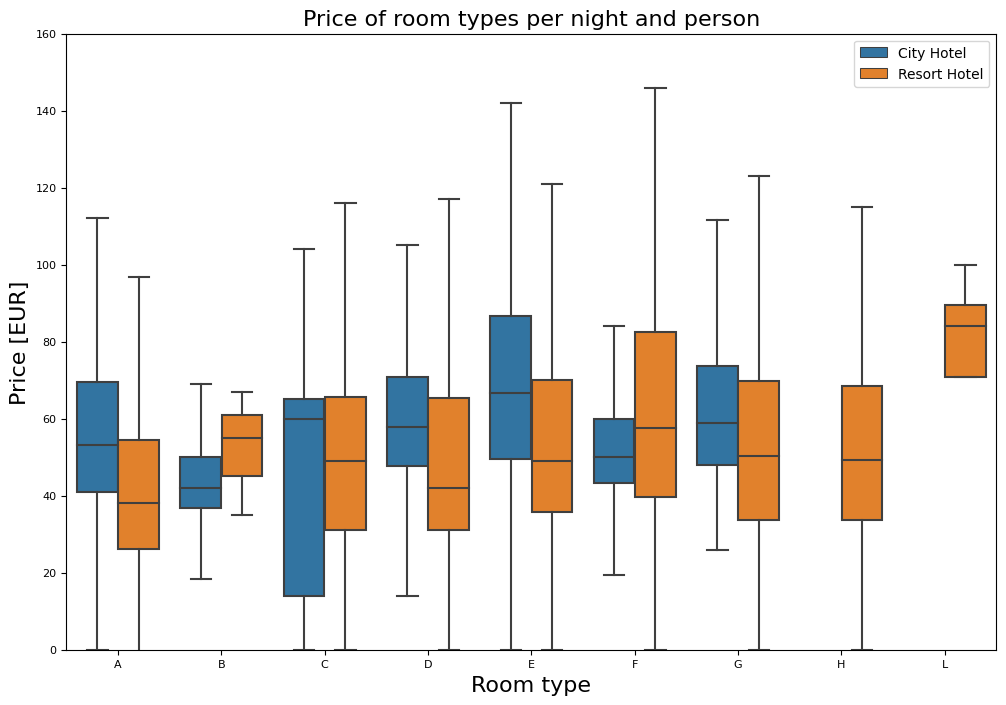

In [ ]:
# Average cost per paying customer
df["adr_pp"] = df["adr"] / (df["adults"] + df["children"])

df_guests = df.loc[df["is_canceled"] == 0] # only actual gusts
room_price = df_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_price,
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show();

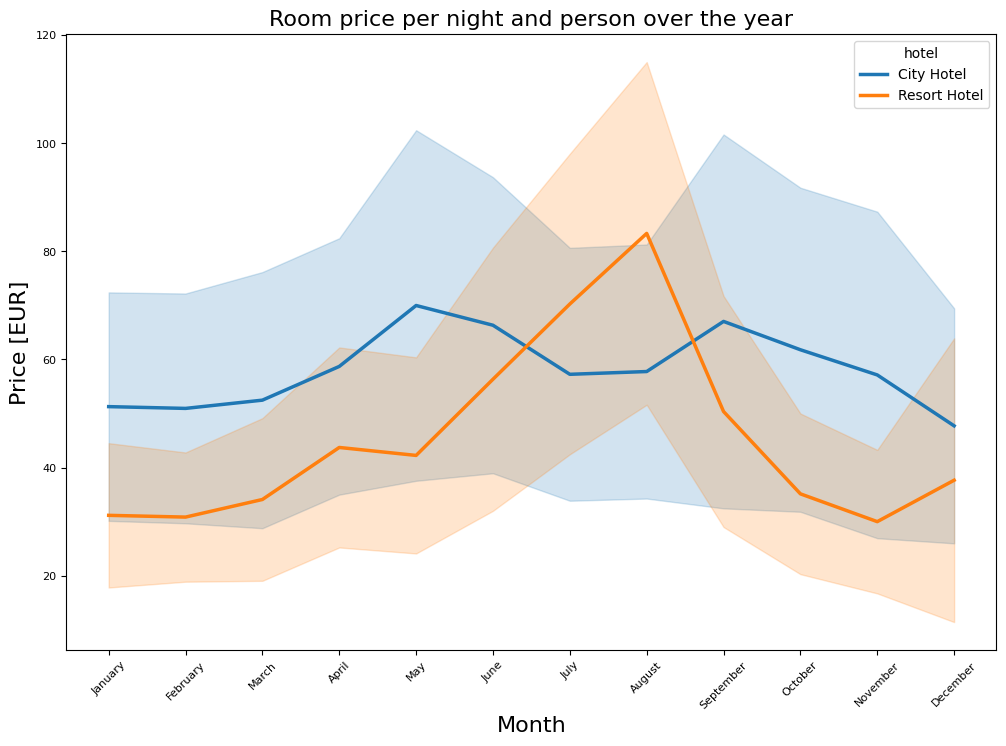

In [ ]:
# grab data:
room_prices_mothly = df_guests[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly,
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show();

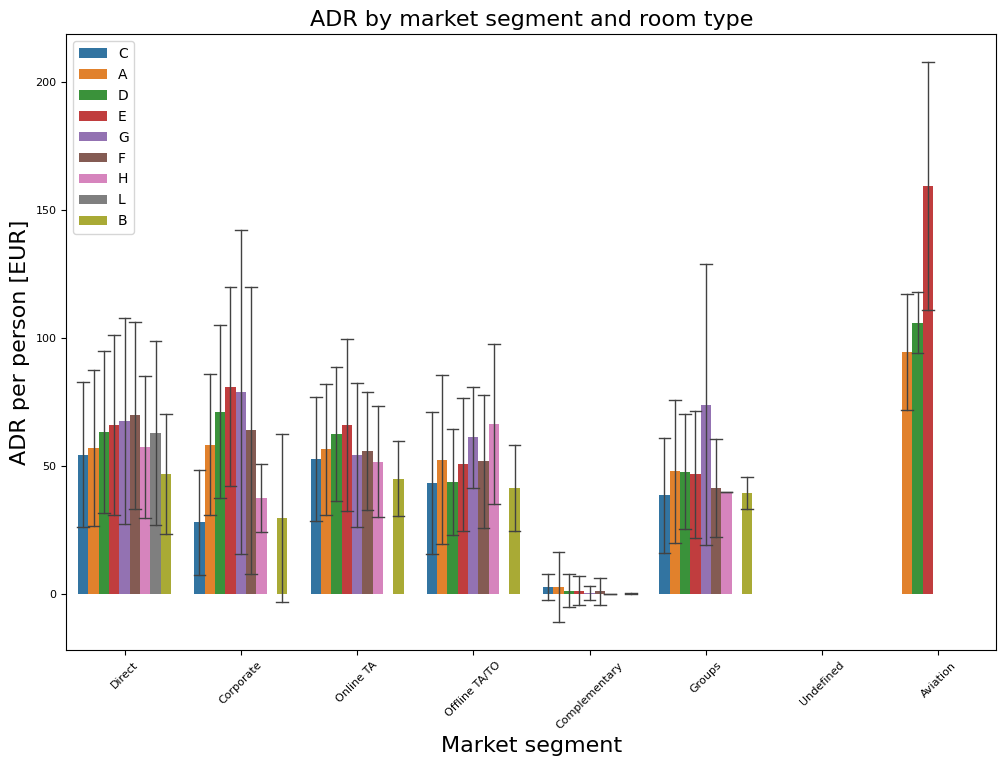

In [ ]:
# price per night (ADR) and person based on booking and room.
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=df,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show();

#### Data splits for the modeling assesments
First let's transform the categorical values. The method below is only tolerable on tree based models. The proper approach is to do a one-hot encoding or use a feature embedding for very high cardinality features. I don't have time to do the latter, unfortunately.

In [ ]:
# dropping columns that are not useful
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general
feats = list(df.drop(columns=['days_in_waiting_list', 'arrival_date_year', 'assigned_room_type', 'booking_changes',
               'reservation_status','reservation_status_date', 'country', 'days_in_waiting_list']).columns)

In [ ]:
num_feats = ['lead_time','arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights',
             'stays_in_week_nights','adults','children','babies','meal','is_repeated_guest','previous_cancellations',
             'previous_bookings_not_cancelled','agent','adr','required_car_parking_spaces',
             'total_of_special_requests','adr_pp']
cat_feats = ['hotel','meal','market_segment','distribution_channel','reserved_room_type','deposit_type','company', 'arrival_date_month',
             'customer_type']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[feats], df['is_canceled'], test_size = 0.1, random_state = 42, stratify=df['is_canceled'])
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size = 0.111, random_state = 42, stratify=y_train)

In [ ]:
# Encode Categorical Columns
le = LabelEncoder()
X_train_enc = X_train.copy()
X_train_enc[cat_feats] = X_train_enc[cat_feats].apply(le.fit_transform)

In [23]:
X_train_enc.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests
111891,0,0,71,8,19,13,2,2,2,0.000,0,3,6,3,0,0,0,0,0,9.000,0,2,130.500,0,2
95924,0,0,181,1,35,25,0,1,2,0.000,0,3,6,3,0,0,0,0,0,9.000,0,2,85.500,0,0
27915,1,0,9,11,38,11,2,2,2,0.000,0,0,6,3,0,0,0,3,0,240.000,0,2,129.000,0,1
44797,0,1,105,10,42,12,1,2,2,0.000,0,2,5,3,0,0,0,0,1,21.000,0,2,110.000,0,0
97674,0,0,70,11,38,16,1,2,2,0.000,0,0,6,3,0,0,0,3,0,9.000,0,2,158.400,1,1


#### Feature selection
Boruta is a powerful feature selection algorithm. It's a wrapper method in a sense that it build a machine learning model, typically Random Forest, that run through multiple iterations of the training process recursively and eliminate useless features at each step

In [26]:
%%time
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=101, max_iter=1000)

feat_selector.fit(X_train_enc.values, y_train)

# check selected features
#print(feat_selector.support_)

# check ranking of features
#print(feat_selector.ranking_)

# call transform() on original df to filter it down to selected features
X_filtered = feat_selector.transform(X_train_enc.values)

ValueError: ignored

NameError: ignored